# figure 2 code

In [ ]:
%load_ext autoreload
%autoreload 2


In [2]:

# figure 1: show all cases on a world map

# setup all the imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # noqa: E402
import numpy as np
import seaborn as sns
import pandas as pd

flist = matplotlib.font_manager.get_font_names()
from pathlib import Path  # noqa: E402

from extremeweatherbench import evaluate, utils, cases, defaults, inputs, metrics, regions

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

import src.plots.paper_plotting as pp  # noqa: E402

# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()
# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources
# to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [3]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

ghcn_group_style = {'linestyle':'-', 'marker':'o', 'group':'GHCN'}
era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}

ifs_group_style = {'linestyle':'-', 'marker':'o', 'group':'IFS'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}

global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}

hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_ifs_cira_settings = {'forecast_source':'CIRA FOURv2 IFS', 'label_str': 'ForecastNet V2'} 
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_ifs_cira_settings = {'forecast_source':'CIRA GC IFS', 'label_str': 'GraphCast'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_ifs_cira_settings = {'forecast_source':'CIRA PANG IFS', 'label_str': 'Pangu Weather'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 

fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | ifs_group_style
gc_ifs_settings = gc_ifs_cira_settings | gc_style | ifs_group_style
pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | ifs_group_style
hres_settings = hres_ifs_settings | hres_style | hres_group_style

In [4]:
# load the results back in
fourv2_heat_results = pd.read_pickle(basepath + 'saved_data/fourv2_heat_results.pkl')
pang_heat_results = pd.read_pickle(basepath + 'saved_data/pang_heat_results.pkl')
hres_heat_results = pd.read_pickle(basepath + 'saved_data/hres_heat_results.pkl')
gc_heat_results = pd.read_pickle(basepath + 'saved_data/gc_heat_results.pkl')


fourv2_freeze_results = pd.read_pickle(basepath + 'saved_data/fourv2_freeze_results.pkl')
pang_freeze_results = pd.read_pickle(basepath + 'saved_data/pang_freeze_results.pkl')
hres_freeze_results = pd.read_pickle(basepath + 'saved_data/hres_freeze_results.pkl')
gc_freeze_results = pd.read_pickle(basepath + 'saved_data/gc_freeze_results.pkl')

In [5]:
# plot north american cases
# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = pp.get_polygon_from_bounding_box(na_bounding_box)
na_bounding_region = regions.BoundingBoxRegion(latitude_min=7, latitude_max=85, longitude_min=-172, longitude_max=-45)

# Europe
eu_bounding_box = [50, -15, 15, 75]
eu_bounding_box_polygon = pp.get_polygon_from_bounding_box(eu_bounding_box)
eu_bounding_region = regions.BoundingBoxRegion(latitude_min=50, latitude_max=75, longitude_min=-15, longitude_max=15)

# break the cases into different lists
na_subset = regions.RegionSubsetter(region=na_bounding_region, method='intersects').subset_case_collection(ewb_cases)
eu_subset = regions.RegionSubsetter(region=eu_bounding_region, method='intersects').subset_case_collection(ewb_cases)

na_case_ids = [n.case_id_number for n in na_subset.cases]
eu_case_ids = [n.case_id_number for n in eu_subset.cases]


In [11]:
fourv2_freeze_results['metric'].unique()

array(['MinimumMeanAbsoluteError', 'RootMeanSquaredError'], dtype=object)

In [6]:
def get_mean(results_df, forecast_source, target_source, metric, init_time, lead_times, case_ids=None):
    subset = pp.subset_results_to_xarray(results_df=results_df, forecast_source=forecast_source, target_source=target_source, metric=metric, init_time=init_time, case_id_list=case_ids)
    subset = subset.sel(lead_time=lead_times)
    return subset["value"].mean(dim='case_id_number').values

def get_relative_error(results_df, hres_results, forecast_source, target_source, metric, init_time, lead_time_days, case_ids=None):
    # down-select to just a few lead-times
    lead_times = [np.timedelta64(lead_time_days[i], "D") for i in range(len(lead_time_days))]
    my_mean = get_mean(results_df, forecast_source, target_source, metric, init_time, lead_times, case_ids)
    hres_mean = get_mean(hres_results, hres_ifs_settings['forecast_source'], target_source, metric, init_time, lead_times, case_ids)
    my_relative_error = (my_mean - hres_mean) / hres_mean * 100
    
    return (my_mean, my_relative_error)

def get_error_array_for_heatmap(results_array, hres_results, forecast_sources, target_source, metric_strs, init_time, lead_time_days):
    """
    This function takes in an array of results and parameters to say which results to grab and returns 
    error arrays and relative arrays for global, north america, and europe.
    """
    # now make the array for the scorecard
    global_rel_error = {}
    global_error = {}

    na_rel_error = {}
    na_error = {}

    eu_rel_error = {}
    eu_error = {}


    for metric in metric_strs:
        # initialize the arrays
        global_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        global_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        na_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        na_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        eu_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        eu_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        for i, results_df in enumerate(results_array):
            my_mean, my_relative_error = get_relative_error(results_df, hres_results, forecast_sources[i], target_source, metric, init_time, lead_time_days)
            global_error[metric][i, :] = my_mean
            global_rel_error[metric][i, :] = my_relative_error

            na_mean, na_relative_error = get_relative_error(results_df, hres_results, forecast_source[i], target_source, metric, init_time, lead_time_days, case_ids=na_case_ids)
            na_error[metric][i, :] = na_mean
            na_rel_error[metric][i, :] = na_relative_error

            eu_mean, eu_relative_error = get_relative_error(results_df, hres_results, forecast_sources[i], target_source, metric, init_time, lead_time_days, case_ids=eu_case_ids)
            eu_error[metric][i, :] = eu_mean
            eu_rel_error[metric][i, :] = eu_relative_error


    return global_error, global_rel_error, na_error, na_rel_error, eu_error, eu_rel_error

# setup for the scorecard
# Grab means for each metric for each model
heat_metric_str = ['MaximumMeanAbsoluteError', 'RootMeanSquaredError', 'MaximumLowestMeanAbsoluteError']
freeze_metric_str = ['MinimumMeanAbsoluteError', 'RootMeanSquaredError']
heat_display_str = ['Maximum MAE', 'RMSE', 'Maximum MAE of Minimum Temperature']
freeze_display_str = ['Minimum MAE', 'RMSE']

lead_time_days = [1, 3, 5, 7, 10]

heat_results_array = [hres_heat_results, fourv2_heat_results, gc_heat_results, pang_heat_results]
forecast_source = [hres_ifs_settings['forecast_source'], fourv2_ifs_settings['forecast_source'], gc_ifs_settings['forecast_source'], pangu_ifs_settings['forecast_source']]
freeze_results_array = [hres_freeze_results, fourv2_freeze_results, gc_freeze_results, pang_freeze_results]

(global_heat_error, global_rel_heat_error, na_heat_error, na_rel_heat_error, eu_heat_error, eu_rel_heat_error) = \
    get_error_array_for_heatmap(heat_results_array, hres_heat_results, forecast_source, 'GHCN', heat_metric_str, 'zeroz', lead_time_days)
(global_freeze_error, global_rel_freeze_error, na_freeze_error, na_rel_freeze_error, eu_freeze_error, eu_rel_freeze_error) = \
    get_error_array_for_heatmap(freeze_results_array, hres_freeze_results, forecast_source, 'GHCN', freeze_metric_str, 'zeroz', lead_time_days)



(30, 36)
plotting the cases for each event type
adding blank subplot 2
adding blank subplot 2
adding blank subplot 2


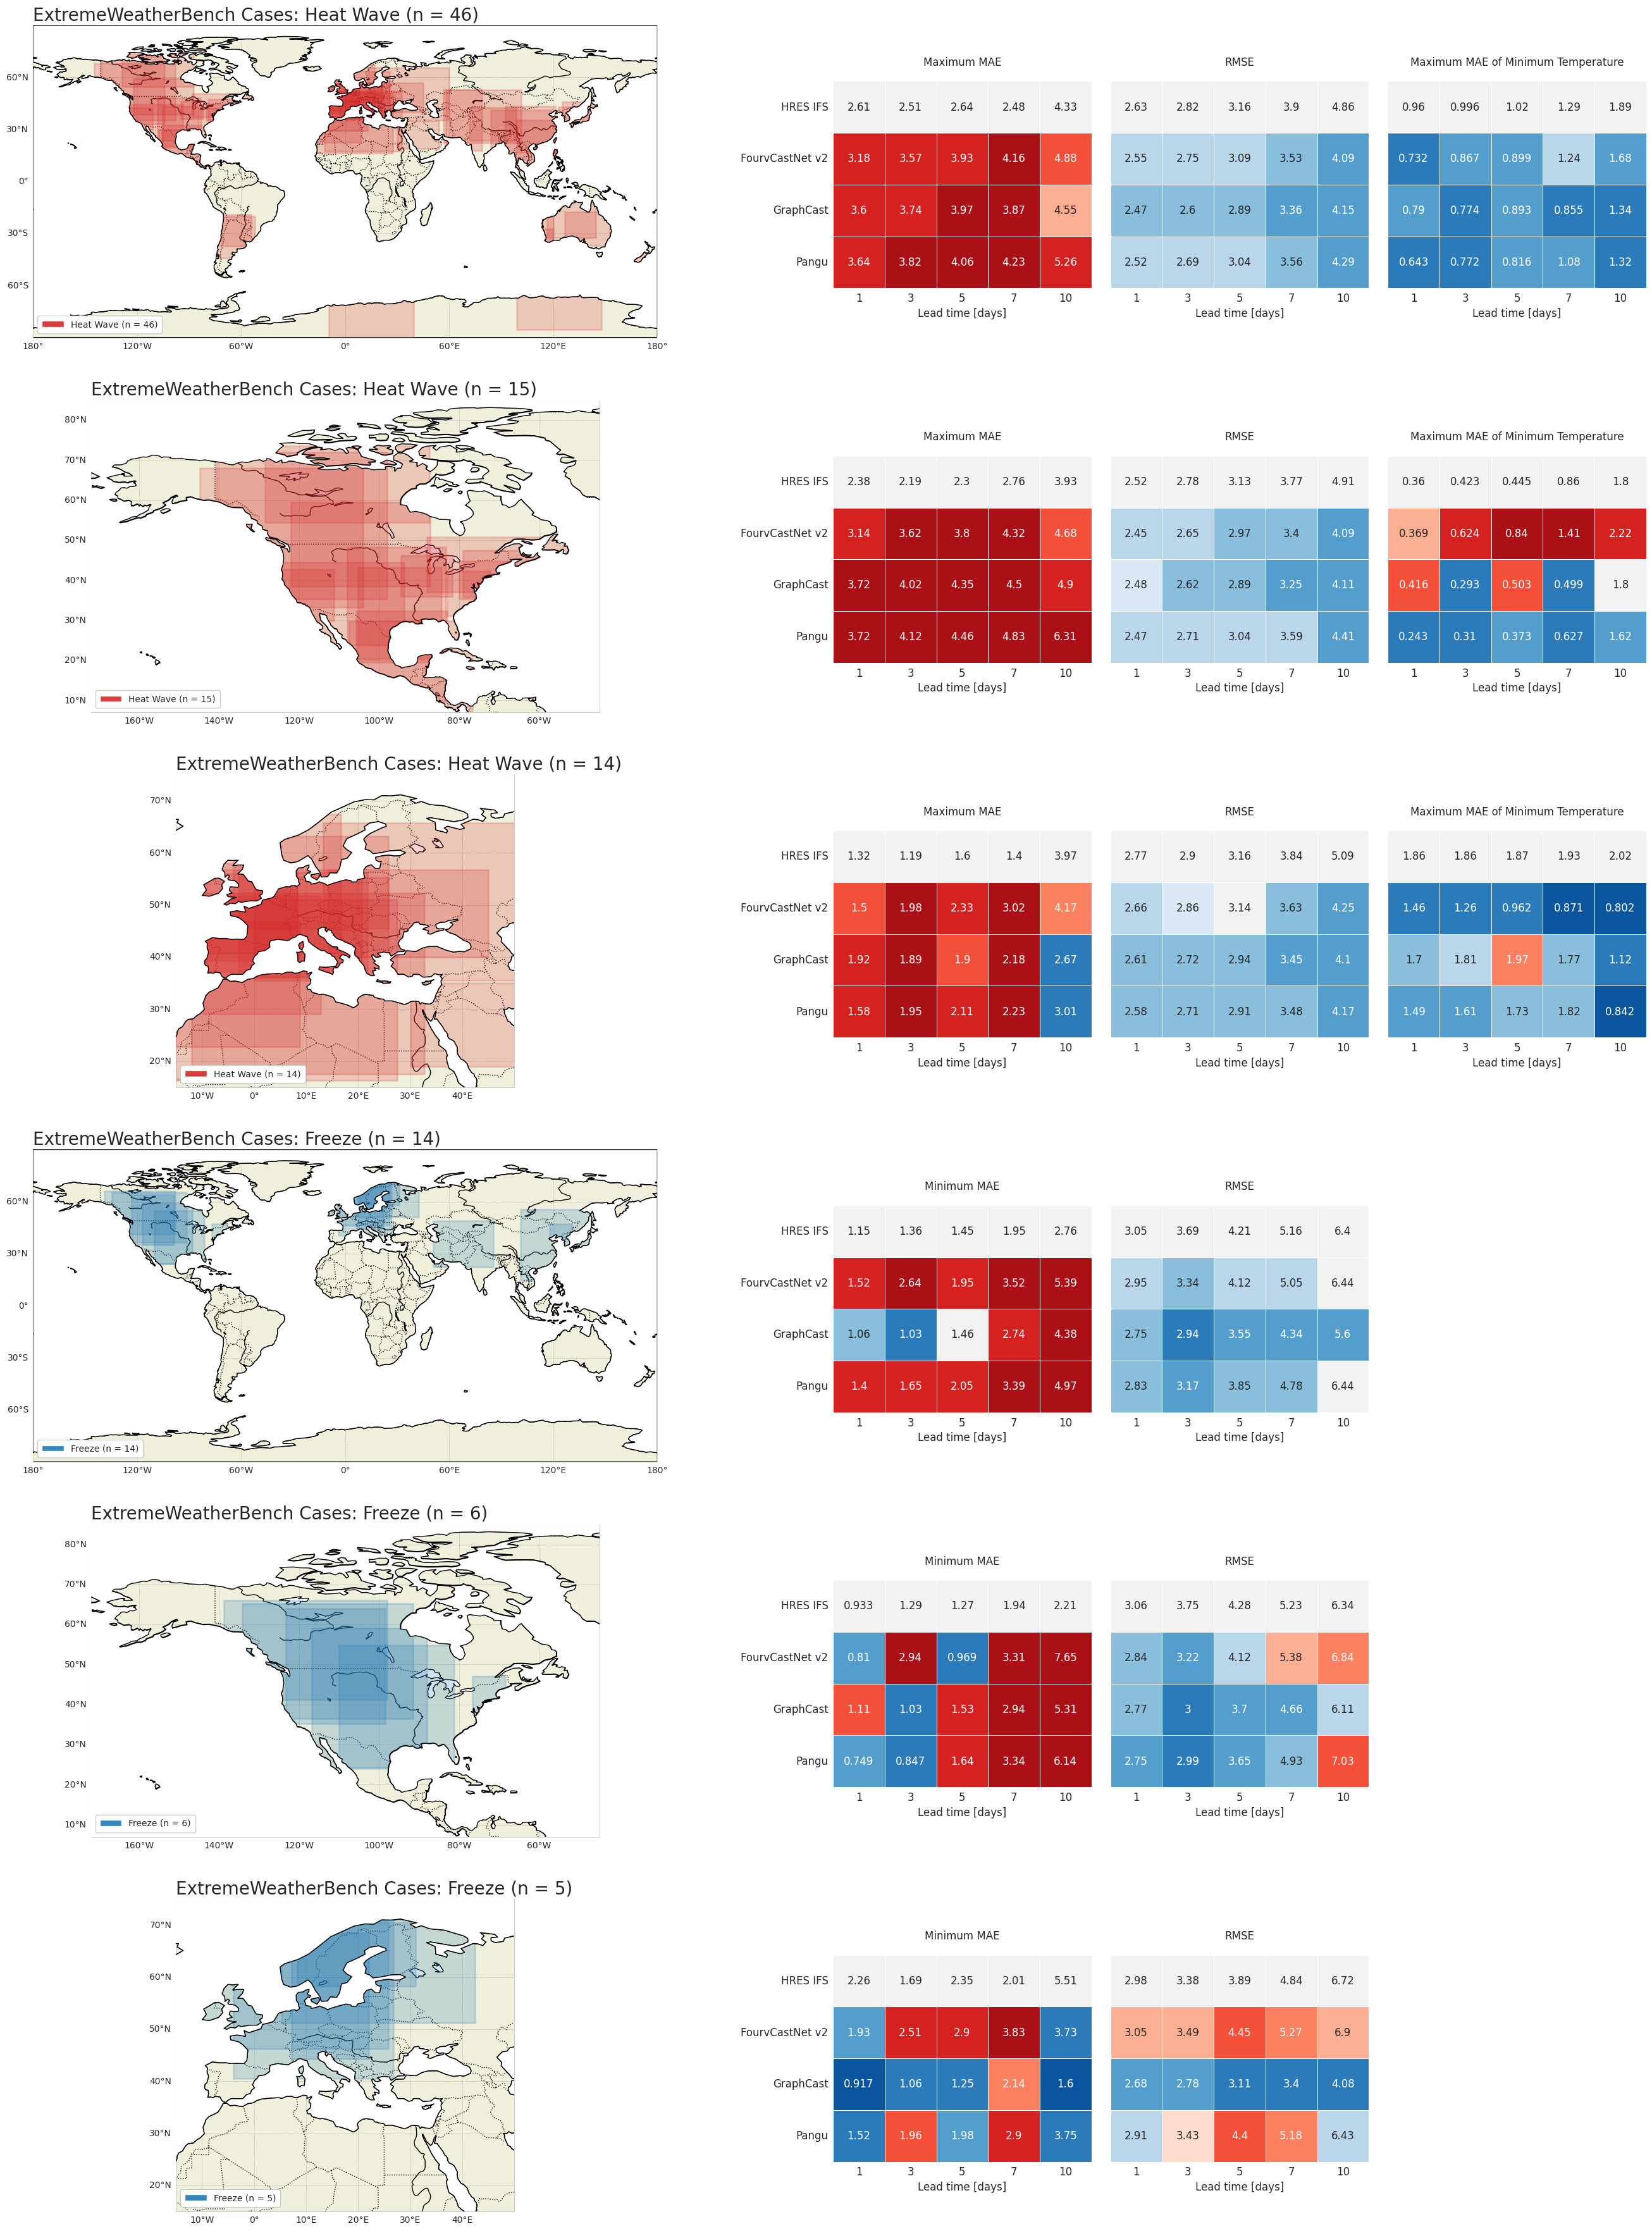

In [7]:
from matplotlib.gridspec import GridSpec

n_rows = 6
n_cols = 2
figsize = (15 * n_cols, 6 * n_rows)
print(figsize)

# Create figure first
fig = plt.figure(figsize=figsize)

# Use GridSpec for better control over subplot sizes, especially with mixed cartopy/regular subplots
# Make column 2 wider for line plots (width_ratios: col0, col1, col2)
# Use negative hspace to compress vertical spacing (negative values allow overlap)
gs = GridSpec(n_rows, n_cols, figure=fig, 
              left=0.05, right=0.95, top=0.98, bottom=0.02,
              wspace=0.1, hspace=0.2,  
              width_ratios=[1, 1])  # Make column 2 (index 2) 1.5x wider

# Create a grid of subplots - specify which ones should use cartopy
# Example: cartopy_subplots = [(0, 0), (1, 0)] means rows 0,1 in column 0 use cartopy
# You can modify this list to specify which subplots need cartopy projections
cartopy_subplots = [(0,0), (1,0), (2,0), (3,0), (4,0), (5,0)]  # Add tuples like (row, col) for subplots that need cartopy

# Create all subplots
axs = []
for i in range(n_rows):
    row = []
    for j in range(n_cols):
        if (i, j) in cartopy_subplots:
            # Create cartopy subplot
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        else:
            # Create regular matplotlib subplot
            ax = fig.add_subplot(gs[i, j])
        row.append(ax)
    axs.append(row)

# Convert to numpy array for easier indexing (matching plt.subplots behavior)
axs = np.array(axs)

# the left hand column of figure one shows all of the cases for each event type
# plot the cases for each event type
print("plotting the cases for each event type")
pp.plot_all_cases(
    ewb_cases,
    event_type="heat_wave",
    fill_boxes=True,
    ax=axs[0, 0],
)

# plot the cases for north america
pp.plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=na_bounding_box, 
               fill_boxes=True, ax=axs[1, 0])

# plot the cases for europe
pp.plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=eu_bounding_box, 
               fill_boxes=True, ax=axs[2, 0])


# do the same for the freeze cases
pp.plot_all_cases(
    ewb_cases,
    event_type="freeze",
    fill_boxes=True,
    ax=axs[3, 0],
)

pp.plot_all_cases(
    ewb_cases,
    event_type="freeze",
    bounding_box=na_bounding_box,
    fill_boxes=True,
    ax=axs[4, 0],
)

pp.plot_all_cases(
    ewb_cases,
    event_type="freeze",
    bounding_box=eu_bounding_box,
    fill_boxes=True,
    ax=axs[5, 0],
)




heat_settings = {}
heat_settings["subplot_titles"] = heat_display_str
heat_settings["metric_str"] = heat_metric_str
heat_settings["lead_time_days"] = lead_time_days
heat_settings["model_order"] = ["HRES IFS", "FourvCastNet v2", "GraphCast", "Pangu"]

freeze_settings = {}
freeze_settings["subplot_titles"] = freeze_display_str
freeze_settings["metric_str"] = freeze_metric_str
freeze_settings["lead_time_days"] = lead_time_days
freeze_settings["model_order"] = ["HRES IFS", "FourvCastNet v2", "GraphCast", "Pangu"]

# second column of figure 2 shows the scorecard
pp.plot_heatmap(
    global_rel_heat_error,
    global_heat_error,
    heat_settings,
    ax=axs[0, 1],
)

pp.plot_heatmap(
    na_rel_heat_error,
    na_heat_error,
    heat_settings,
    ax=axs[1, 1],
)

pp.plot_heatmap(
    eu_rel_heat_error,
    eu_heat_error,
    heat_settings,
    ax=axs[2, 1],)

pp.plot_heatmap(
    global_rel_freeze_error,
    global_freeze_error,
    freeze_settings,
    ax=axs[3, 1],
)

pp.plot_heatmap(
    na_rel_freeze_error,
    na_freeze_error,
    freeze_settings,
    ax=axs[4, 1],
)

pp.plot_heatmap(
    eu_rel_freeze_error,
    eu_freeze_error,
    freeze_settings,
    ax=axs[5, 1],
)
#fig.subplots_adjust(hspace=0.0)  # Set hspace to 0 to remove all vertical spacing

#fig.savefig(basepath + "docs/notebooks/figs/figure2.png", dpi=600)

In [ ]:
# second column of figure 2 shows the scorecard
pp.plot_heatmap(
    global_rel_heat_error,
    global_heat_error,
    heat_settings,
)